In [8]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.metrics import silhouette_score
from scipy.optimize import minimize
from scipy.stats import dirichlet

In [9]:
TICKERS = [
    # Technology
    'AAPL', 'MSFT', 'GOOGL', 'NVDA','AMZN', 'META', 'INTC', 'AMD', 'CSCO',

    # Healthcare
    'JNJ', 'PFE', 'MRK', 'UNH', 'ABBV', 'BMY', 'GILD', 'REGN', 'VRTX', 'LLY',

    # Energy
    'XOM', 'CVX', 'SLB', 'BP', 'COP', 'OXY', 'EOG', 'KMI', 'PSX', 'HAL',

    # Financials
    'JPM', 'GS', 'BRK-B', 'C', 'BAC', 'WFC', 'MS', 'AXP', 'BLK', 'SCHW',

    # Consumer Staples
    'KO', 'PEP', 'PG', 'WMT', 'MO', 'CL', 'KMB', 'EL', 'STZ', 'COST',

    # Consumer Discretionary
    'DIS', 'TSLA', 'NFLX', 'HD', 'NKE', 'SBUX', 'MCD', 'TGT', 'LOW',

    # Industrials
    'BA', 'CAT', 'UPS', 'LMT', 'MMM', 'GE', 'HON', 'DE', 'UNP', 'CSX',

    # Telecommunications
    'VZ', 'T', 'TMUS', 'CHT', 'CMCSA', 'EA', 'NOK', 'ERIC', 'CCI', 'SBAC',

    # ETFs
    'SPY', 'QQQ', 'VTI', 'EWW', 'IEMG', 'EFA', 'VWO', 'IXC', 'XLE', 'XLF',
]

In [10]:
data = yf.download(TICKERS, start="2014-01-01", end="2024-12-31")['Close']

[*********************100%***********************]  88 of 88 completed


In [11]:
# Calculate Logarithmic Returns
returns = np.log(data / data.shift(1)).dropna()

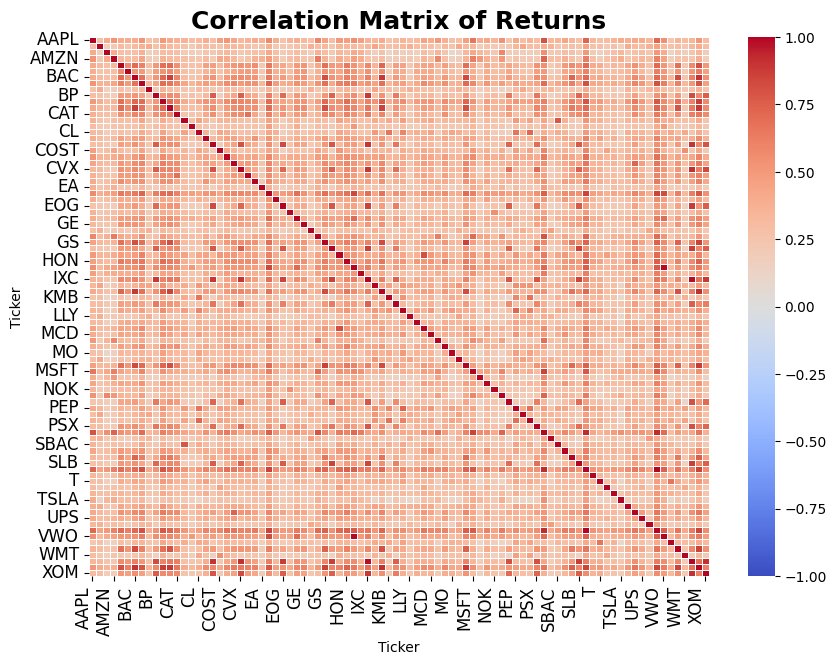

In [25]:
# Correlation Matrix
correlation_matrix = returns.corr()

# Adjust figure size based on the number of assets
plt.figure(figsize=(10,7))

sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm',  # Remove values
            vmin=-1, vmax=1,  # Limit colorbar range
            linewidths=0.5,  # Cell borders
            linecolor='white')  # Change cell border color

# Improve presentation
plt.title("Correlation Matrix of Returns", fontsize=18, fontweight='bold')
plt.xticks(rotation=90, ha='right', fontsize=12)  # Increase column label size
plt.yticks(rotation=0, fontsize=12)  # Increase row label size

plt.show()

In [13]:
# Normalize the data for Hierarchical Clustering
scaler = StandardScaler()
scaled_returns = scaler.fit_transform(returns.T)

# Convert the correlation matrix to a distance matrix (1 - correlation)
distance_matrix = 1 - correlation_matrix
# Convert the distance matrix to condensed form
condensed_distance_matrix = squareform(distance_matrix)

In [14]:
# Generate the linkage with the best linkage method
Z = linkage(condensed_distance_matrix, method='ward')  # You can change the method here

# Calculate the optimal number of clusters using the Dendrogram (using the optimal threshold)
distances = Z[:, 2]  # Extract the distances
distance_diff = np.diff(distances)  # Difference between consecutive distances
threshold_index = np.argmax(distance_diff)  # Largest gap in the distance
optimal_threshold = distances[threshold_index]  # Optimal threshold

# Use fcluster to obtain clusters based on the threshold
clusters = fcluster(Z, optimal_threshold, criterion='distance') 

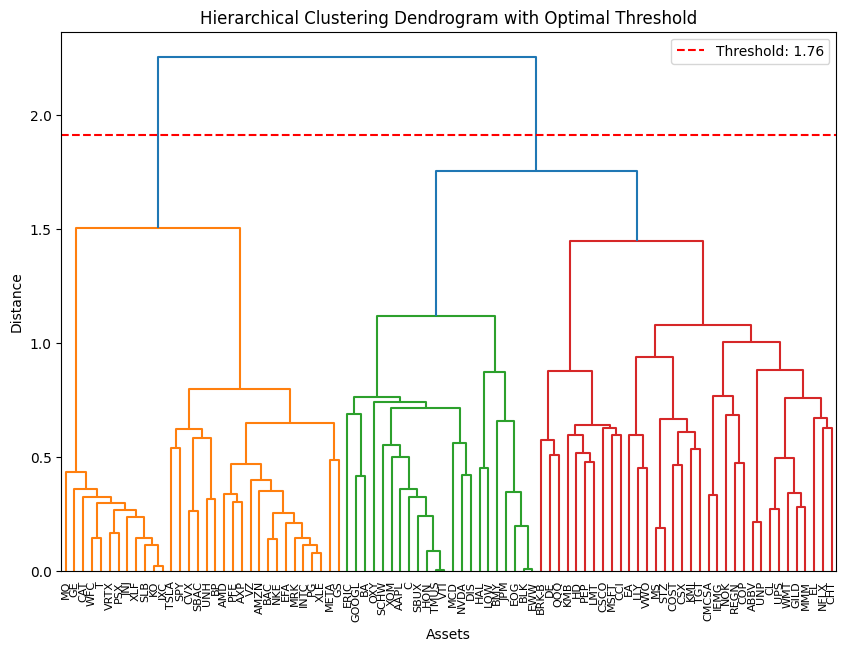

Optimal number of clusters (Dendrogram): 2
Optimal Threshold: 1.76


In [15]:
# Get the optimal number of clusters from the dendrogram
optimal_k_dendrogram = len(set(clusters))

# Plot the Dendrogram with the optimal threshold
plt.figure(figsize=(10, 7))
dendrogram(Z, labels=TICKERS, leaf_rotation=90, leaf_font_size=8)
separation = optimal_threshold * 1.09
plt.axhline(y=separation, color='r', linestyle='--', label=f'Threshold: {optimal_threshold:.2f}')
plt.title("Hierarchical Clustering Dendrogram with Optimal Threshold")
plt.xlabel("Assets")
plt.ylabel("Distance")
plt.legend()
plt.show()

# Print the optimal number of clusters from the Dendrogram
print(f"Optimal number of clusters (Dendrogram): {optimal_k_dendrogram}")
print(f"Optimal Threshold: {optimal_threshold:.2f}")

In [16]:
# Independent Evaluation with the Silhouette Score (not dependent on the dendrogram)

def evaluate_silhouette(k, linkage_method, metric, data):
    try:
        # Perform clustering and calculate the Silhouette Score
        clustering = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)
        labels = clustering.fit_predict(data)
        return silhouette_score(data, labels, metric=metric)
    except Exception as e:
        print(f"Error evaluating k={k} with {linkage_method} and metric {metric}: {e}")
        return -1  # Return an invalid value if there's an error

# Initialize evaluation variables
best_score = -1
optimal_k_silhouette = 0

# Dictionary to store results only for the best linkage method and metric
silhouette_scores = {}

# The range of k goes from a minimum value to a dynamic maximum value
min_k = 3  # Minimum value of k, you can adjust it as needed
max_k = len(TICKERS)  # Maximum value of k will be the total number of assets
metrics = ['euclidean', 'manhattan', 'cosine']
methods = ['ward', 'complete', 'average', 'single']

# Evaluation for different values of k, linkage method, and metrics
for k in range(min_k, max_k):  # We use the dynamic range
    for linkage_method in methods:
        for metric in metrics:
            score = evaluate_silhouette(k, linkage_method, metric, scaled_returns)
            if score != -1:  # Only store valid results
                if score > best_score:
                    best_score = score
                    best_linkage = linkage_method
                    best_metric = metric
                    optimal_k_silhouette = k  # Update the optimal k when a better score is found

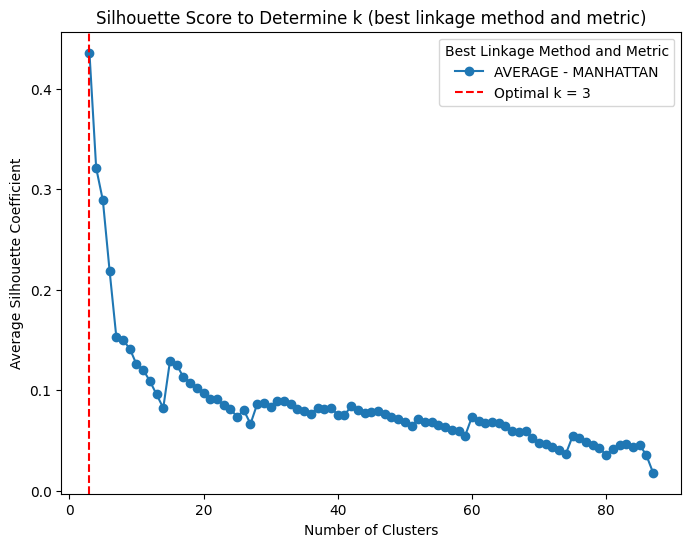

Best linkage method: AVERAGE with metric MANHATTAN and 3 clusters and Silhouette Score: 0.44


In [17]:
# 2. Plot the Silhouette Score vs. Number of Clusters for the best method and metric
# Only take the values corresponding to the best method and metric
plt.figure(figsize=(8, 6))

# Recalculate the Silhouette Score for the values of k with the best method and metric
best_method_scores = []
for k in range(min_k, max_k):
    score = evaluate_silhouette(k, best_linkage, best_metric, scaled_returns)
    if score != -1:
        best_method_scores.append((k, score))

# Convert to DataFrame for easier visualization
df_scores = pd.DataFrame(best_method_scores, columns=["k", "score"])

# Plot the result
plt.plot(df_scores['k'], df_scores['score'], marker='o', label=f'{best_linkage.upper()} - {best_metric.upper()}')

# 3. Add a vertical line for the optimal k
plt.axvline(x=optimal_k_silhouette, color='red', linestyle='--', label=f'Optimal k = {optimal_k_silhouette}')

# Titles and labels
plt.title("Silhouette Score to Determine k (best linkage method and metric)")
plt.xlabel("Number of Clusters")
plt.ylabel("Average Silhouette Coefficient")
plt.legend(title="Best Linkage Method and Metric")
plt.show()

# Print the best result based on the Silhouette Score
print(f"Best linkage method: {best_linkage.upper()} with metric {best_metric.upper()} and {optimal_k_silhouette} clusters and Silhouette Score: {best_score:.2f}")

In [18]:
# Apply Hierarchical Clustering with the optimal number of clusters
agglomerative_clustering = AgglomerativeClustering(n_clusters=optimal_k_silhouette, linkage=best_linkage)
labels = agglomerative_clustering.fit_predict(scaled_returns)

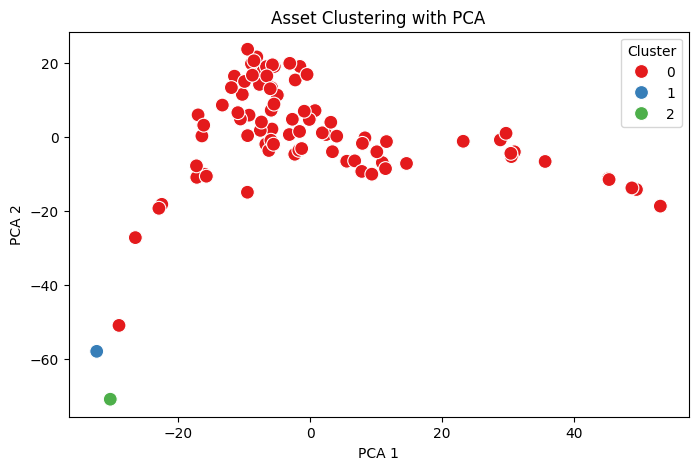

In [19]:
# Visualize Clusters with PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_returns)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette='Set1', s=100)
plt.title("Asset Clustering with PCA")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend(title="Cluster")
plt.show()

In [20]:
# Select a Representative Asset from Each Cluster based on Average Return
df_cluster = pd.DataFrame({'Ticker': TICKERS, 'Cluster': labels})

risk_free_rate = 0.03 / 252  # Convert to daily returns 

def select_optimal_asset(assets_in_cluster):
    valid_assets = set(assets_in_cluster) & set(returns.columns)  # Intersection between both sets
    if not valid_assets:
        return None

    # Convert the intersection back to a list
    valid_assets = list(valid_assets)
    
    average_returns = returns[valid_assets].mean()
    volatilities = returns[valid_assets].std() + 1e-8  # Add a small value to avoid division by zero
    sharpe_ratios = (average_returns - risk_free_rate) / volatilities
    
    return sharpe_ratios.idxmax()  # Return the ticker with the highest Sharpe ratio

# Select the optimal assets from each cluster
selected_assets = df_cluster.groupby('Cluster')['Ticker'].apply(select_optimal_asset).dropna().values

# Show selected assets for portfolio optimization
print("Selected Assets for Portfolio Optimization:", selected_assets.tolist())

Selected Assets for Portfolio Optimization: ['NVDA', 'ERIC', 'GOOGL']


In [21]:
# Get returns and covariance matrix of selected assets
selected_returns = returns[selected_assets]
average_returns = selected_returns.mean()  
cov_matrix = selected_returns.cov()    

# 3. Optimization function to find the best asset combination
def regularized_sharpe_ratio(weights, average_returns, cov_matrix, lambda_ridge=0.05):
    return_expected_return = np.sum(weights * average_returns)  # Expected return of the portfolio
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Portfolio volatility
    regularization = lambda_ridge * np.sum(weights**2)  # Regularization term (Ridge)
    return -((return_expected_return - risk_free_rate) / portfolio_volatility) + regularization  # Minimize regularized Sharpe Ratio

# 2. Efficient Frontier Optimization
# Required parameters
num_assets = len(selected_assets)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Constraint that weights sum to 1
volatilities = np.sqrt(np.diag(cov_matrix))  # Volatility of each asset
bounds = tuple((0.01, min(0.50, 1 / vol)) for vol in volatilities)  # Limit weights between 0.01 and 0.50 or 1/volatility

# Initial random weights
initial_weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]  

# Perform optimization
optimization_result = minimize(regularized_sharpe_ratio, initial_weights, args=(average_returns, cov_matrix),
                                method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = optimization_result.x  # Optimal weights found

In [22]:
# Calculate expected return and risk of the optimal portfolio
portfolio_return = np.sum(optimal_weights * average_returns)  # Expected return of the portfolio
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))  # Portfolio risk
optimal_sharpe = (portfolio_return - risk_free_rate) / (portfolio_volatility + 1e-8)  # Sharpe ratio of the optimal portfolio

# Generate random portfolios for the efficient frontier
num_portfolios = 10000  # Number of portfolios to generate
results = np.zeros((3, num_portfolios))  # Return, Risk, Sharpe Ratio
weights_record = np.zeros((num_portfolios, num_assets))  # Record of weights for each portfolio

for portfolio_idx in range(num_portfolios):
    weights = np.random.uniform(0.01, 0.50, num_assets)  # Weights between 0.01 and 0.50 for each asset
    weights /= np.sum(weights)  # Normalize to sum to 1 (fully invested portfolio)
    
    # Record the generated weights for this portfolio
    weights_record[portfolio_idx, :] = weights
    # Calculate expected return of the portfolio
    return_portfolio = np.dot(weights, average_returns)  # Use np.dot for efficient multiplication (weighted sum)
    # Calculate portfolio volatility (risk) using the covariance matrix
    volatility_portfolio = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))  # Calculate volatility
    # Calculate Sharpe ratio for this portfolio (adjusted for risk-free rate)
    sharpe = (return_portfolio - risk_free_rate) / volatility_portfolio if volatility_portfolio != 0 else 0  # Adjusted Sharpe ratio
    # Record portfolio results: return, risk, Sharpe
    results[:, portfolio_idx] = [return_portfolio, volatility_portfolio, sharpe]

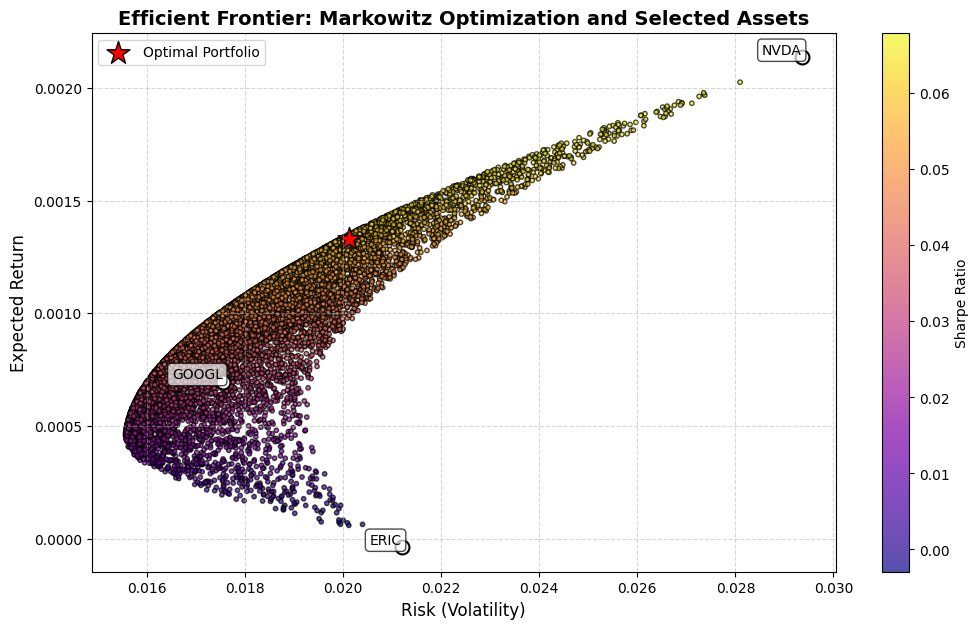

Optimal portfolio weights based on hierarchical clustering and Markowitz optimization:
NVDA: 50.00%
ERIC: 12.00%
GOOGL: 38.00%
Expected Return of the Optimal Portfolio: 0.13%
Volatility of the Optimal Portfolio: 2.01%
Sharpe Ratio of the Optimal Portfolio: 0.0601


In [23]:
# Efficient Frontier Visualization
plt.figure(figsize=(12, 7))

# Plot the efficient frontier with more visible colors
scatter = plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='plasma', alpha=0.7, edgecolors='k', s=10)
plt.colorbar(scatter, label='Sharpe Ratio')

# Highlight the optimal portfolio with a striking color
plt.scatter(portfolio_volatility, portfolio_return, color='red', edgecolors='black', marker='*', s=300, label='Optimal Portfolio')

# Plot selected assets with labels and better visibility
asset_volatilities = np.sqrt(np.diag(cov_matrix))  # Volatilities of selected assets
for asset, vol, ret in zip(selected_assets, asset_volatilities, average_returns):
    plt.scatter(vol, ret, color='white', edgecolors='black', marker='o', s=100, linewidth=1.5)  # Selected assets
    plt.text(vol, ret, asset, fontsize=10, ha='right', va='bottom', bbox=dict(facecolor='white', alpha=0.7, edgecolor='black', boxstyle='round,pad=0.3'))

# Improve presentation
plt.xlabel('Risk (Volatility)', fontsize=12)
plt.ylabel('Expected Return', fontsize=12)
plt.title('Efficient Frontier: Markowitz Optimization and Selected Assets', fontsize=14, fontweight='bold')
plt.legend(fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

plt.show()

# 6. Final Results
print("Optimal portfolio weights based on hierarchical clustering and Markowitz optimization:")
for asset, weight in zip(selected_assets, optimal_weights):
    print(f"{asset}: {weight:.2%}")

print(f"Expected Return of the Optimal Portfolio: {portfolio_return:.2%}")
print(f"Volatility of the Optimal Portfolio: {portfolio_volatility:.2%}")
print(f"Sharpe Ratio of the Optimal Portfolio: {optimal_sharpe:.4f}")

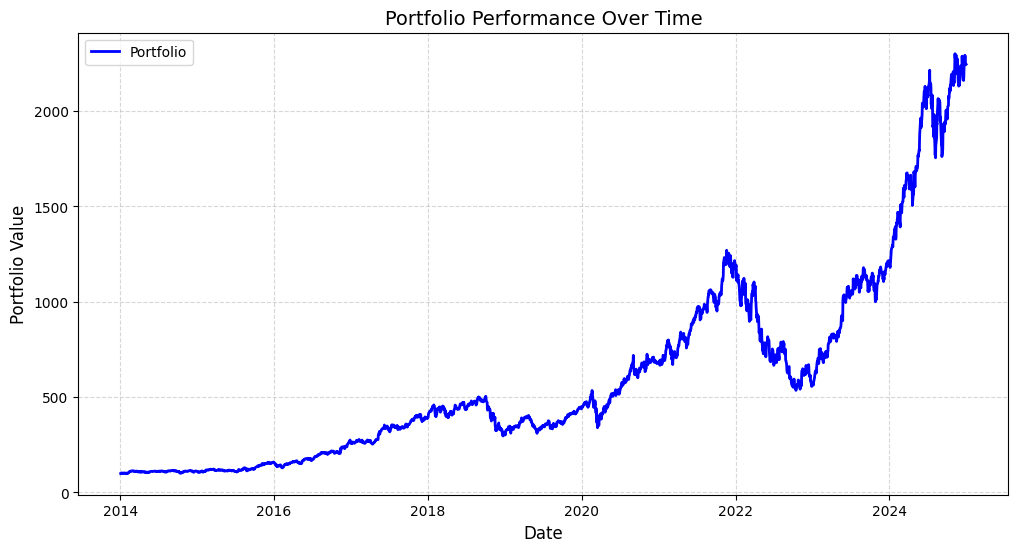

In [24]:
# Calculate the portfolio returns (already calculated earlier)
portfolio_returns = np.dot(selected_returns, optimal_weights)  # Weighted portfolio returns

# Calculate the accumulated portfolio prices
# Let's assume we start with an initial value of 100 (you can normalize to 1 if you'd prefer)
initial_portfolio_value = 100  # You can adjust this value if needed
historical_portfolio_prices = (1 + portfolio_returns).cumprod() * initial_portfolio_value  # Accumulated price

# Plot the historical prices of the portfolio
plt.figure(figsize=(12, 6))
plt.plot(selected_returns.index, historical_portfolio_prices, label='Portfolio', color='b', linewidth=2)

# Add labels and title
plt.title('Portfolio Performance Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)

# Show the plot
plt.show()